In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA

from time import time 
from datetime import datetime
from datetime import timedelta


In [6]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [7]:
df = pd.read_csv('ice_cream.csv', parse_dates = [0], date_parser = parser, index_col = 0)

/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_23811/1260992344.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('ice_cream.csv', parse_dates = [0], date_parser = parser, index_col = 0)


In [8]:
df

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223


In [12]:
df = df.rename(columns = {'IPN31152N' : 'prod'})

In [19]:
# to infer the frequency
df = df.asfreq(pd.infer_freq(df.index))

In [20]:
# to infer the frequency
df = df.loc['2010-01-01': ]

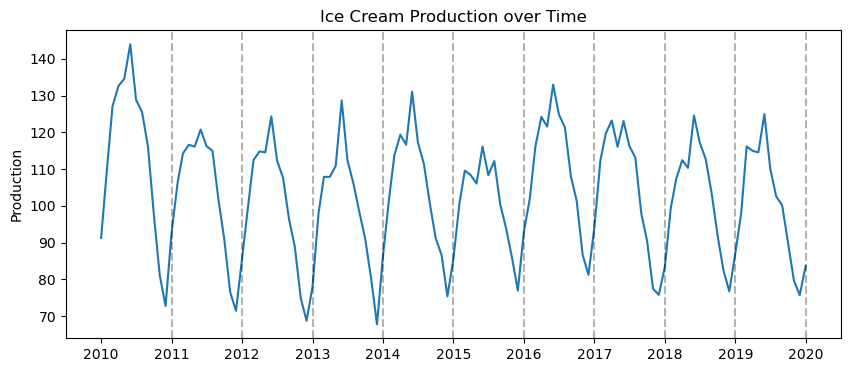

In [25]:
plt.figure(figsize = (10, 4))

plt.plot(df)
plt.title('Ice Cream Production over Time')
plt.ylabel('Production')

for year in range(2011, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.3) 

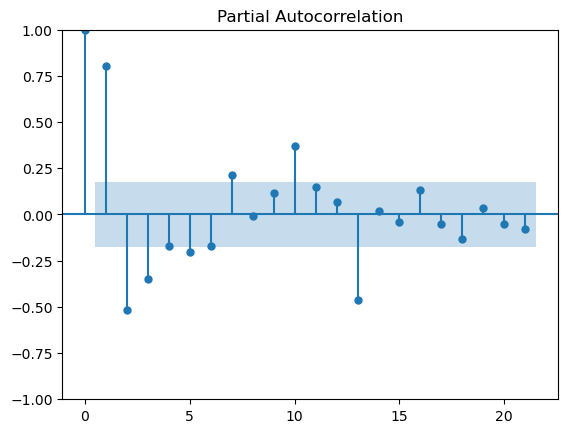

In [26]:
pacf_plot = plot_pacf(df)

#### based on PACF, we should make an AR model with lags 1,2,3 

## Train and Test set


In [68]:
train_df = df.loc[:'2017-01-01']
test_df = df.loc['2017-01-01':]

## Fit the AR Model

### NOTE: ARIMA with d=0 is ARMA

ARMA model no longer exist on python 


In [69]:
model = ARIMA(train_df, order = (3, 0, 0)) 

In [70]:
model_fit = model.fit()

In [71]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   prod   No. Observations:                   85
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -298.157
Date:                Fri, 02 Aug 2024   AIC                            606.314
Time:                        19:37:36   BIC                            618.527
Sample:                    01-01-2010   HQIC                           611.226
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.8885      2.479     41.905      0.000      99.030     108.748
ar.L1          1.0443      0.118      8.856      0.000       0.813       1.275
ar.L2         -0.0698      0.207     -0.338      0.736      -0.475       0.336
ar.L3         -0.3819      0.144     -2.644      0.008      -0.665      -0.099
sigma2        63.5005     11.692      5.431      0.000      40.585      86.416
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                 4.70
Prob(Q):                              0.39   Prob(JB):                         0.10
Heteroskedasticity (H):               0.88   Skew:                             0.57
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## NOTE:

the main attention should be on $ P > |z| $ values in the above summary, called as p value. The lower the value, more important that term is, if value is above 0.5, we can ignore that particular lag

So, based on the value, we see lag 2 is not that important, so we can ignore that while constructing our model  

In [72]:
## get prediction for test_data

predictions = model_fit.predict(start = test_df.index[0], end = test_df.index[-1])


In [73]:
test_df['pred'] =  predictions

/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_23811/101427705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] =  predictions


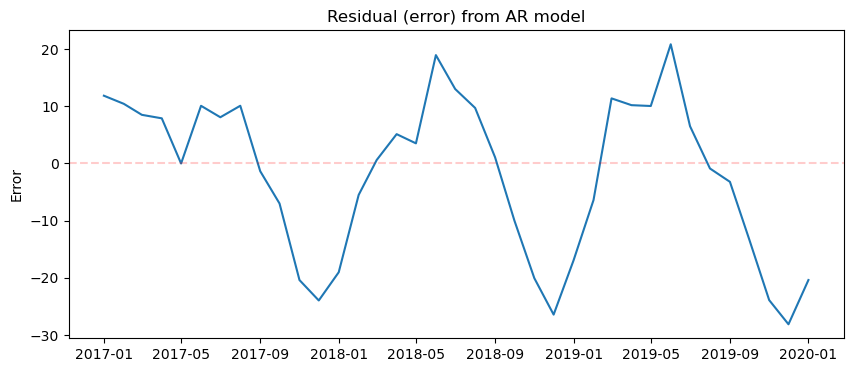

In [74]:
# Plotting the difference between true value and prediction

plt.figure(figsize = (10, 4))

plt.plot(test_df['prod'] - test_df['pred'])
plt.title('Residual (error) from AR model')
plt.ylabel('Error')
plt.axhline(0, color = 'r', linestyle = '--', alpha = 0.2)


Text(0, 0.5, 'Production')

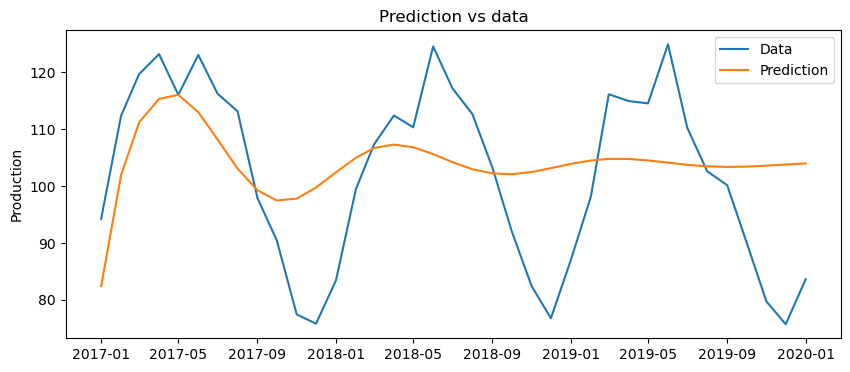

In [75]:
plt.figure(figsize = (10, 4))

plt.plot(test_df['prod'])
plt.plot(test_df['pred'])
plt.legend(('Data', 'Prediction'))
plt.title('Prediction vs data' )
plt.ylabel('Production')


We see the residual has some seasonality, which means on some level there is correlation, which is not good. So the current model needs to be further modified. 
Apart from that, in the above plot, we see that we are not making good predcition after 2018


### Comment on train-test split for time series data
Train-test split (80-20) split is not good for the time series data as we dont want to predict something very much in future, based on very old past. As the past result, might not take into account the recent trend coming from other sources. Instead one uses a ROLLING FORECAST ORIGIN


#### ROLLING FORECAST ORIGIN
**Idea**: Predict one month in advance each time 

- Train on months 1,2, .... k-3 and predict k-2
- Train on months 1,2, .... k-3, k-2 and predict k-1
- Train on months 1,2, .... k-3, k-2, k-1 and predict k
- And average all the prediction 

This is called rolling window 


In [93]:
## CREATE THE MODEL 

prediction_rolling = pd.Series()

for end_date in test_df.index:

    train_df = df[:pd.Timestamp(end_date) - timedelta(days =  1)] # timestamp needed for arithmetic operation
    model = ARIMA(train_df, order = (3, 0, 0)) 
    model_fit = model.fit()

    pred = model_fit.predict(end_date)
    prediction_rolling.loc[end_date] = pred.loc[end_date]

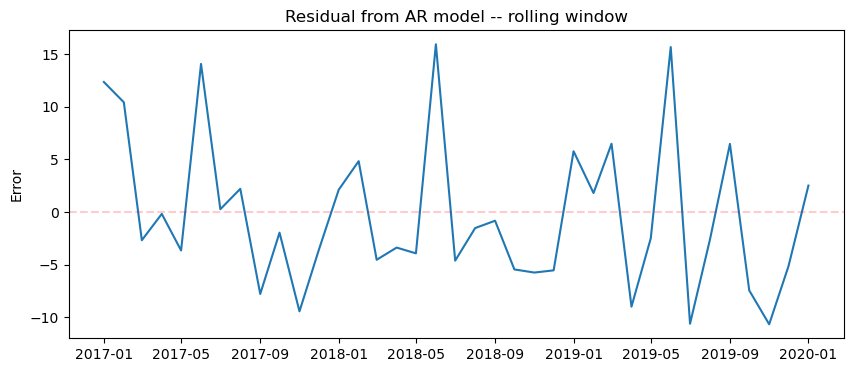

In [98]:
# plotting residuals from rolling window

plt.figure(figsize = (10, 4))

plt.plot(test_df['prod'] - prediction_rolling)
plt.title('Residual from AR model -- rolling window')
plt.ylabel('Error')
plt.axhline(0, color = 'r', linestyle = '--', alpha = 0.2)

Text(0, 0.5, 'Production')

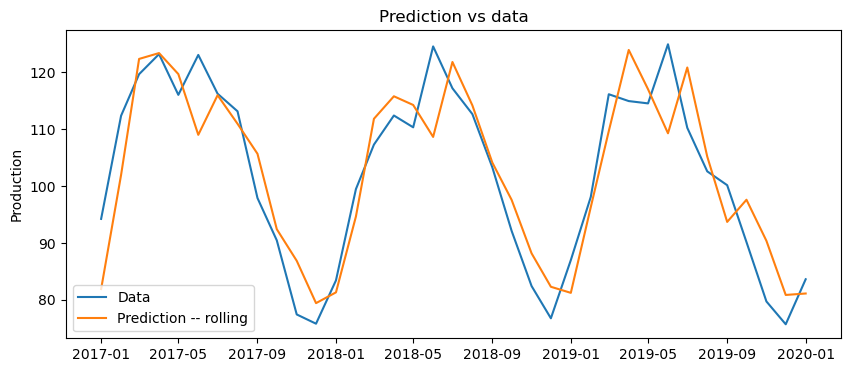

In [100]:
plt.figure(figsize = (10, 4))

plt.plot(test_df['prod'])
plt.plot(prediction_rolling)
plt.legend(('Data', 'Prediction -- rolling'))
plt.title('Prediction vs data' )
plt.ylabel('Production')
